DE-GP- Regression Example in PyTorch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import numpy as np
import scipy as sp
import random
import copy
import time
from functools import partial

# for NN
import torch
import torch.nn as nn
import torch.nn.functional as F

# for NNGP
import neural_tangents as nt
from neural_tangents import stax

# for HMC and VI
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import seaborn as sns

from utils_degp import ParallelPriorLinear, ParallelPriorConv2d, gp_sample_and_estimate_kl

#prepare
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 10})

np.random.seed(101)
random.seed(101)
torch.manual_seed(101)

# general settings
dataset = 2
if dataset == 2:
    n_hidden = 512 	# no. hidden units in NN
    n_layer = 3
    data_noise = 0.01
    xlim = [-3, 3]
    ylim = [-3, 3]
else:
    n_hidden = 512 	# no. hidden units in NN
    n_layer = 3
    data_noise = 0.001 # estimated noise variance    
    xlim = [-1.7, 1.5]
    ylim = [-3, 1.5]


activation_fn = 'relu' # relu erf
W_var=2. 
b_var=1.
W1_var = W_var
b1_var = b_var
W2_var = W_var/n_hidden
b2_var = b_var

# optimisation options for NN
epochs = 300
l_rate = 0.003 		# learning rate

# for ensemble
n_ensemble = 50	# no. NNs in ensemble

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/jovyan/utils_degp.py:26: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


In [2]:
# utils
class Erf(torch.nn.Module):
    def __init__(self):
        super(Erf, self).__init__()
    
    def forward(self, x):
        return x.erf()

class Idt(torch.nn.Module):
    def __init__(self):
        super(Idt, self).__init__()
    
    def forward(self, x):
        return x
        
def fn_make_data(dataset = 0):
    # create some data
    if dataset == 0:
        x_train = np.atleast_2d([1., 4.5, 5.1, 6., 8., 9.]).T
        x_train = x_train/5. - 1
        y_train = x_train * np.sin(x_train*5.) + np.random.normal(loc=0.,scale=0.2, size=x_train.shape)
    elif dataset == 2:
        x_train = np.atleast_2d(np.concatenate([np.linspace(-1.5,-0.6,10), np.linspace(.6,1.5,10)])).T
        y_train =  x_train**3/4. + np.random.normal(loc=0.,scale=0.1, size=x_train.shape)
    else:
        raise NotImplementedError

    y_train = y_train - y_train.mean()

    # create validation data - here we'll just a 1-d grid
    x_val = np.atleast_2d(np.linspace(-3, 3, 100)).T
    y_val = np.expand_dims(x_val[:,0],1) # just dummy data
    
    return x_train, y_train, x_val, y_val

def fn_make_NN(activation_fn, n_layer=1, n_hidden=100, dropout=0.):
    D_in, D_out = 1, 1 # input and output dimension
    
    if activation_fn == 'relu':
        mid_act = torch.nn.ReLU()
    elif activation_fn == 'erf':
        mid_act = Erf()
    elif activation_fn == 'idt':
        mid_act = Idt()
    
    layers = [torch.nn.Linear(D_in, n_hidden),
        mid_act,
        torch.nn.Dropout(dropout),
        torch.nn.Linear(n_hidden, D_out, bias=False)]
    for _ in range(n_layer - 1):
        layers.insert(3, torch.nn.Linear(n_hidden, n_hidden))
        layers.insert(4, mid_act)
        layers.insert(5, torch.nn.Dropout(dropout))
    model = torch.nn.Sequential(*layers)
    return model

def init_NN(model, W1_var, b1_var, W2_var, b2_var):
    # initialise weights
    model[0].weight.data.normal_(0.0, np.sqrt(W1_var))
    if model[0].bias is not None:
        model[0].bias.data.normal_(0.0, np.sqrt(b1_var))
    for n, p in model[1:].named_parameters():
        if 'bias' in n:
            p.data.normal_(0.0, np.sqrt(b2_var))
        else:
            p.data.normal_(0.0, np.sqrt(W2_var))
    
def fn_make_prior_NN(activation_fn, n_ensembles, W_var, b_var, n_hidden=100):
    D_in, D_out = 1, 1 # input and output dimension
    
    if activation_fn == 'relu':
        mid_act = torch.nn.ReLU()
    elif activation_fn == 'erf':
        mid_act = Erf()
    elif activation_fn == 'idt':
        mid_act = Idt()
        
    layers = []
    for i, n_ensemble in enumerate(n_ensembles):
        in_features, out_features, bias = n_hidden, n_hidden, True
        if i == 0:
            in_features = D_in
        layers.append(ParallelPriorLinear(n_ensemble, in_features, out_features, W_var=W_var, b_var=b_var, bias=bias))
        layers.append(mid_act)

    model = torch.nn.Sequential(*layers)
    return model

def fn_predict_ensemble(NNs, x_test):
    ''' fn to predict given a list of NNs (an ensemble)''' 
    y_preds = []
    with torch.no_grad():
        for m in range(len(NNs)):
            y_preds.append(NNs[m](torch.tensor(x_test).float()).data.numpy())
    y_preds = np.array(y_preds)

    y_preds_mu = np.mean(y_preds,axis=0)
    y_preds_std = np.std(y_preds,axis=0)

    return y_preds, y_preds_mu, y_preds_std

def plot(x_test, y_preds, y_preds_mu, y_preds_std, data_noise, not_apply_data_noise=False,
         show_preds=True, show_mu_std=False, show_trains=False, title=None, xlim=[-3, 3], ylim=[-3, 3]):

    # plot predictive distribution
    if not not_apply_data_noise and y_preds_std is not None:
        y_preds_std = np.sqrt(np.square(y_preds_std) + data_noise) 
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    if show_preds:
        for m in range(0,n_ensemble):
            ax.plot(x_test, y_preds[m], 'k')
    if show_mu_std:
        ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
        ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
        ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
        ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
        ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
        ax.fill(np.concatenate([x_test, x_test[::-1]]),
                 np.concatenate([y_preds_mu - 2 * y_preds_std,
                                (y_preds_mu + 2 * y_preds_std)[::-1]]),
                 alpha=1, fc='lightskyblue', ec='None')
        ax.fill(np.concatenate([x_test, x_test[::-1]]),
                 np.concatenate([y_preds_mu - 1 * y_preds_std,
                                (y_preds_mu + 1 * y_preds_std)[::-1]]),
                 alpha=1, fc='deepskyblue', ec='None')
    if show_trains:
        ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
                markeredgecolor='k',markeredgewidth=0.5)

    ax.set_ylim(*ylim)
    ax.set_xlim(*xlim)

    plt.xticks([])
    plt.yticks([])
    
    if title:
        fig.savefig(title +'.pdf', format='pdf', dpi=1000, bbox_inches='tight')
    else:
        fig.show()

# create some data
x_train, y_train, x_test, y_test = fn_make_data(dataset)
plot = partial(plot, xlim=xlim, ylim=ylim)

marg_log_like [[6.35654781]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: covariance is not positive-semidefinite.


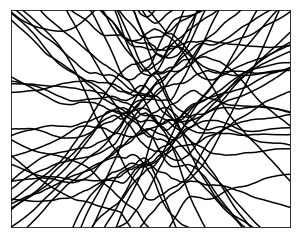

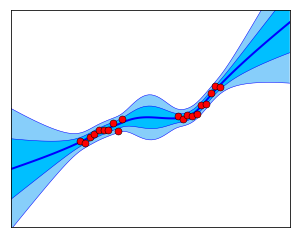

In [3]:
def nngp(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
         W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, empirical=False):
    
    layers = [stax.Dense(n_hidden, W_std=math.sqrt(W1_var), b_std=math.sqrt(b1_var), parameterization='standard'),
        stax.Relu() if activation_fn == 'relu' else stax.Erf(),
        stax.Dense(1, W_std=math.sqrt(W2_var*n_hidden), b_std=0, parameterization='standard')
    ]
    for _ in range(n_layer - 1):
        layers.insert(2, stax.Dense(n_hidden, W_std=math.sqrt(W2_var*n_hidden), b_std=math.sqrt(b2_var), 
                                    parameterization='standard'))
        layers.insert(3, stax.Relu() if activation_fn == 'relu' else stax.Erf())
    init_fn, apply_fn, kernel_fn = stax.serial(*layers)
    
    if empirical:
        from jax import random
        key1, key2, key3 = random.split(random.PRNGKey(1), 3)
        _, params = init_fn(key3, x_train.shape)
        kernel_fn = nt.empirical_kernel_fn(apply_fn, trace_axes=(-1,), vmap_axes=0, implementation=1)
        cov_dd = kernel_fn(x_train, None, 'nngp', params) + np.identity(x_train.shape[0])*data_noise
        cov_xd = kernel_fn(x_test, x_train, 'nngp', params)
        cov_xx = kernel_fn(x_test, None, 'nngp', params)
    else:
        cov_dd = kernel_fn(x_train, None, 'nngp') + np.identity(x_train.shape[0])*data_noise
        cov_xd = kernel_fn(x_test, x_train, 'nngp')
        cov_xx = kernel_fn(x_test, None, 'nngp')
    
    L = np.linalg.cholesky(cov_dd)
    alpha = np.linalg.solve(L.T,np.linalg.solve(L,y_train))
    y_pred_mu = np.matmul(cov_xd,alpha)
    v = np.linalg.solve(L,cov_xd.T)
    cov_pred = cov_xx - np.matmul(v.T,v)

    y_pred_var = np.atleast_2d(np.diag(cov_pred) + data_noise).T
    y_pred_std = np.sqrt(y_pred_var)
    
    marg_log_like = - np.matmul(y_train.T,alpha)/2 - np.sum(np.log(np.diag(L))) - x_train.shape[0]*np.log(2*np.pi)/2
    print('marg_log_like', marg_log_like)
    
    # visualize priors
    y_samples_prior = np.random.multivariate_normal(
        np.zeros(x_test.shape[0]), cov_xx, n_ensemble) # mean, covariance, size
    plot(x_test, y_samples_prior, None, None, data_noise, not_apply_data_noise=True,
         show_preds=True, show_mu_std=False, show_trains=False)
    
    # visualize posteriors
    plot(x_test, None, y_pred_mu, y_pred_std, data_noise, not_apply_data_noise=True,
         show_preds=False, show_mu_std=True, show_trains=True, title='nngp_h{}'.format(n_hidden))

nngp(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
     W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, empirical=False)

Sequential(
  (0): ParallelPriorLinear()
  (1): ReLU()
  (2): ParallelPriorLinear()
  (3): ReLU()
  (4): ParallelPriorLinear()
  (5): ReLU()
)


  0%|          | 0/300 [00:00<?, ?it/s]

Sequential(
  (0): Linear(in_features=1, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.0, inplace=False)
  (9): Linear(in_features=512, out_features=1, bias=False)
)


/home/jovyan/.local/lib/python3.6/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
100%|██████████| 300/300 [01:08<00:00,  4.40it/s]

0.02328679084777832 0.0021603545082693925
0.0021276402473449705 0.0003630090890559757
0.004323227405548096 0.0004817408502077485
0.18522095918655396 0.010827812950609621
0.21495861768722535 0.011793070679344531


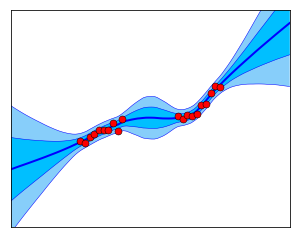

In [4]:
def gp_ensemble(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
                W_var, b_var, W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, kl_weight=1., 
                n_ensembles_ref=None, n_hidden_ref=None, ip=None):
    x = torch.tensor(x_train).float()
    y = torch.tensor(y_train).float()
    # set up loss
    loss_fn = torch.nn.MSELoss()
    
    if n_ensembles_ref is None:
        n_ensembles_ref = [n_ensemble,] * (n_layer)
    elif isinstance(n_ensembles_ref, int):
        n_ensembles_ref = [n_ensembles_ref,] * (n_layer)
    if n_hidden_ref is None:
        n_hidden_ref = n_hidden
    NN_ref = fn_make_prior_NN(activation_fn, n_ensembles_ref, W_var, b_var, n_hidden_ref)
    
    print(NN_ref)
    
    # create the NNs
    NNs, params = [], []
    for m in range(n_ensemble):
        NNs.append(fn_make_NN(activation_fn, n_layer, n_hidden))
        init_NN(NNs[-1], W1_var, b1_var, W2_var, b2_var)
        for p in NNs[m].parameters():
            params.append(p)
    print(NNs[-1])
    optimizer = torch.optim.Adam(params, lr=l_rate)

    NNs_hist_train=[]
    kls = []
    
    t1, t2, t3, t4 = [], [], [], []
    for _ in tqdm(range(epochs)):
        for layer in range(n_layer+1):
            tmp = 0
            for m in range(n_ensemble):
                tmp += NNs[m][layer * 3].weight.data.view(-1).norm() ** 2
        if ip is None:
            input = x
        elif ip == 'uniform':
            input = torch.cat([x, torch.empty_like(x).uniform_(-3, 3)], 0)
        else:
            raise NotImplementedError
            
        last_time = -time.time()
        outputs = [NNs[m](input) for m in range(n_ensemble)]
        t1.append(time.time() + last_time); last_time = -time.time()
        
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                y_preds_ref = NN_ref(input)
        t2.append(time.time() + last_time); last_time = -time.time()
        
        y_pred_samples, kl = gp_sample_and_estimate_kl(torch.stack(outputs, 0),
            y_preds_ref, 256, 1e-4, W1_var, b_var)
        y_pred_samples = y_pred_samples[:, :, :y.shape[0]].permute(0, 2, 1).flatten(0,1)

        loss = loss_fn(y_pred_samples, y.repeat(256, 1))
        NNs_hist_train.append(loss.item())
        
        kl = kl / input.size(0)*data_noise*2
        kls.append(kl.item())
        
        t3.append(time.time() + last_time); last_time = -time.time()
        
        # run gradient update
        optimizer.zero_grad()
        ((loss + kl_weight * kl) * n_ensemble).backward()
        optimizer.step()
        
        t4.append(time.time() + last_time); last_time = -time.time()
        
    print(np.mean(t1[-100:]), np.std(t1[-100:]))
    print(np.mean(t2[-100:]), np.std(t2[-100:]))
    print(np.mean(t3[-100:]), np.std(t3[-100:]))
    print(np.mean(t4[-100:]), np.std(t4[-100:]))
    print(np.mean(np.array(t1[-100:])+np.array(t2[-100:])+np.array(t3[-100:])+np.array(t4[-100:])), 
          np.std(np.array(t1[-100:])+np.array(t2[-100:])+np.array(t3[-100:])+np.array(t4[-100:])))

    # run predictions
    y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)
    plot(x_test, y_preds, y_preds_mu, y_preds_std, data_noise,
         show_preds=False, show_mu_std=True, show_trains=True, title='degp_h{}{}'.format(n_hidden, '_nottrainanc'))

gp_ensemble(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
            W_var, b_var, W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, ip='uniform',
            n_ensembles_ref=10, n_hidden_ref=64)

100%|██████████| 300/300 [01:25<00:00,  3.51it/s]


0.021170680522918702 0.0020752181179595577
0.04384670734405518 0.004695729792328808
0.20121366262435914 0.010381328240225684
0.266231050491333 0.01472183460945059


100%|██████████| 300/300 [01:19<00:00,  3.79it/s]


0.021353936195373534 0.0020652518686296688
0.03009347677230835 0.0031726497942563383
0.20770657300949097 0.009612039949737573
0.2591539859771729 0.011816590757464024


100%|██████████| 300/300 [01:03<00:00,  4.75it/s]


0.022077305316925047 0.003175166872326455
0.0017088580131530762 0.00024395855445468346
0.18432992696762085 0.010069534725563312
0.20811609029769898 0.010942938859364744


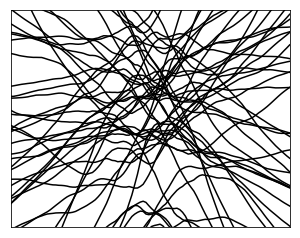

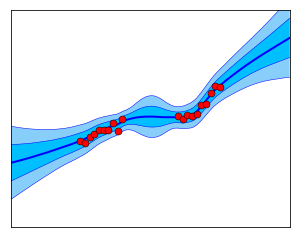

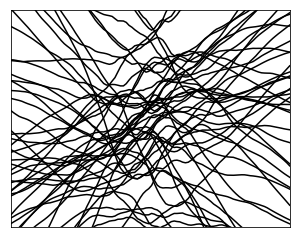

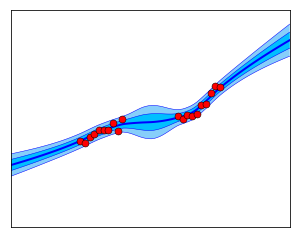

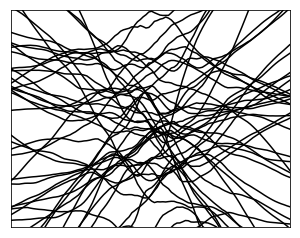

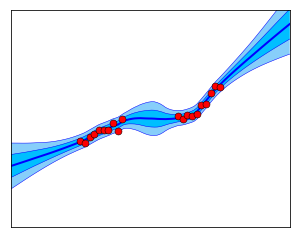

In [5]:
def anchored_ensemble(x_train, y_train, x_test, reg, data_noise, n_ensemble, activation_fn, 
                      W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden):
    x = torch.tensor(x_train).float()
    y = torch.tensor(y_train).float()
    # set up loss
    loss_fn = torch.nn.MSELoss()
    
    # create the NNs
    anchor_NNs=[]
    for m in range(n_ensemble):
        anchor_NNs.append(fn_make_NN(activation_fn, n_layer, n_hidden))
        init_NN(anchor_NNs[-1], W1_var, b1_var, W2_var, b2_var)
        for p in anchor_NNs[-1].parameters():
            p.requires_grad_(False)
    
    NNs, params = [], []
    for m in range(n_ensemble):
        NNs.append(fn_make_NN(activation_fn, n_layer, n_hidden))
        init_NN(NNs[-1], W1_var, b1_var, W2_var, b2_var)
        for p in NNs[m].parameters():
            params.append(p)
    optimizer = torch.optim.Adam(params, lr=l_rate)
    
    # plot priors
    y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)
    plot(x_test, y_preds, None, None, data_noise,
         show_preds=True, show_mu_std=False, show_trains=False)
    
    # do training
    NNs_hist_train=[[] for _ in range(n_ensemble)]
    t1, t2, t3 = [], [], []
    for _ in tqdm(range(epochs)):
        losses, l2s, y_preds = [], [], []
        
        last_time = -time.time()
        for m in range(n_ensemble):
            y_preds.append(NNs[m](x))
        t1.append(time.time() + last_time); last_time = -time.time()
            
        for m in range(n_ensemble):
            losses.append(loss_fn(y_preds[m], y))
            NNs_hist_train[m].append(losses[m].item())
        
        for m in range(n_ensemble):
            # set up reg loss
            l2 = 0
            if reg == 'anc':
                l2 += ((NNs[m][0].weight - anchor_NNs[m][0].weight)**2).sum() / W1_var
                l2 += ((NNs[m][0].bias - anchor_NNs[m][0].bias)**2).sum() / b1_var
                for p1, p2 in zip(list(NNs[m][1:].parameters()), list(anchor_NNs[m][1:].parameters())):
                    l2 += ((p1 - p2)**2).sum() / (b2_var if p1.dim() == 1 else W2_var)
            elif reg == 'reg':
                l2 += (NNs[m][0].weight**2).sum() / W1_var
                l2 += (NNs[m][0].bias**2).sum() / b1_var
                for p in NNs[m][1:].parameters():
                    l2 += (p**2).sum() / (b2_var if p.dim() == 1 else W2_var)
            elif reg == 'free':
                # do nothing
                l2 += 0.0
            else:
                raise NotImplementedError
            l2 = l2 / x.size(0) * data_noise
            l2s.append(l2)
        
        t2.append(time.time() + last_time); last_time = -time.time()

        # run gradient update
        optimizer.zero_grad()
        (sum(losses) + sum(l2s)).backward()
        optimizer.step()
        
        t3.append(time.time() + last_time); last_time = -time.time()
    
    print(np.mean(t1[-100:]), np.std(t1[-100:]))
    print(np.mean(t2[-100:]), np.std(t2[-100:]))
    print(np.mean(t3[-100:]), np.std(t3[-100:]))
    print(np.mean(np.array(t1[-100:])+np.array(t2[-100:])+np.array(t3[-100:])), 
          np.std(np.array(t1[-100:])+np.array(t2[-100:])+np.array(t3[-100:])))

    # run predictions
    y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)
    plot(x_test, None, y_preds_mu, y_preds_std, data_noise, 
         show_preds=False, show_mu_std=True, show_trains=True, title=reg+'_weight_h{}'.format(n_hidden))
    
anchored_ensemble(x_train, y_train, x_test, 'anc', data_noise, n_ensemble, activation_fn, 
                  W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden)
anchored_ensemble(x_train, y_train, x_test, 'reg', data_noise, n_ensemble, activation_fn, 
                  W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden)
anchored_ensemble(x_train, y_train, x_test, 'free', data_noise, n_ensemble, activation_fn, 
                  W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden)

marg_log_like [[6.49038163]]


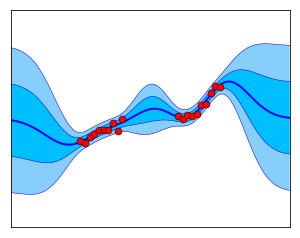

In [6]:
def rbf_kernel(x1, x2, sigma=1., l=0.1):
    if x2 is None:
        x2 = x1
    if isinstance(x1, np.ndarray):
        return np.exp(((x1[:, None, :] - x2[None, :, :])**2).sum(-1)/(-2)/(l**2)) * (sigma**2)
    else:
        return torch.exp(((x1[:, None, :] - x2[None, :, :])**2).sum(-1)/(-2)/(l**2)) * (sigma**2)
    
def gp(x_train, y_train, x_test, data_noise, sigma=1., l=0.1):
    
    cov_dd = rbf_kernel(x_train, None, sigma, l) + np.identity(x_train.shape[0])*data_noise
    cov_xd = rbf_kernel(x_test, x_train, sigma, l)
    cov_xx = rbf_kernel(x_test, None, sigma, l)
    
    L = np.linalg.cholesky(cov_dd)
    alpha = np.linalg.solve(L.T,np.linalg.solve(L,y_train))
    y_pred_mu = np.matmul(cov_xd,alpha)
    v = np.linalg.solve(L,cov_xd.T)
    cov_pred = cov_xx - np.matmul(v.T,v)

    y_pred_var = np.atleast_2d(np.diag(cov_pred) + data_noise).T
    y_pred_std = np.sqrt(y_pred_var)
    
    marg_log_like = - np.matmul(y_train.T,alpha)/2 - np.sum(np.log(np.diag(L))) - x_train.shape[0]*np.log(2*np.pi)/2
    print('marg_log_like', marg_log_like)
    
    # visualize posteriors
    plot(x_test, None, y_pred_mu, y_pred_std, data_noise, not_apply_data_noise=True,
         show_preds=False, show_mu_std=True, show_trains=True, title='gp')

gp(x_train, y_train, x_test, data_noise, sigma=1, l=0.6)

100%|██████████| 300/300 [00:01<00:00, 189.44it/s]


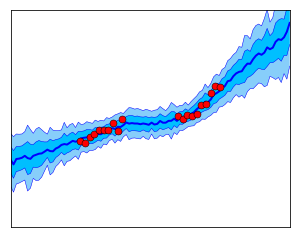

In [7]:
def mc_dropout(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
               W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, dropout=0.):
    x = torch.tensor(x_train).float()
    y = torch.tensor(y_train).float()
    
    # create the NNs
    NN=fn_make_NN(activation_fn, n_layer, n_hidden, dropout=dropout)
    init_NN(NN, W1_var, b1_var, W2_var, b2_var)

    # do training
    NN_hist_train=[]
    # set up loss
    loss_fn = torch.nn.MSELoss()
    
    params = []
    for p in NN.parameters():
        if p.requires_grad:
            params.append(p)
    optimizer = torch.optim.Adam(params, lr=l_rate)
    
    for _ in tqdm(range(epochs)):
        loss = loss_fn(NN(x), y)
        NN_hist_train.append(loss.item())
        # run gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # run predictions
    with torch.no_grad():
        y_preds = torch.stack([NN(torch.tensor(x_test).float()) for _ in range(n_ensemble)], 0).data.cpu().numpy()
    y_preds_mu = np.mean(y_preds,axis=0)
    y_preds_std = np.std(y_preds,axis=0)
    plot(x_test, None, y_preds_mu, y_preds_std, data_noise,
         show_preds=False, show_mu_std=True, show_trains=True, title='mcd_h{}'.format(n_hidden))

mc_dropout(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
           W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, dropout=0.2)

In [8]:
n_inf_samples = 2000 # number samples to take during inference
n_pred_samples = 200 # number samples to take during prediction
vi_steps = 200000 # number optimisation steps to run for VI 

def build_model_pm(total_size, ann_input, ann_output, data_noise, activation_fn, 
                   W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden):
    with pm.Model() as model:
        for i in range(n_layer+1):
            n_in = 1 if i == 0 else n_hidden
            n_out = 1 if i == n_layer else n_hidden
            W_var = W1_var if i == 0 else W2_var
            b_var = b1_var if i == 0 else b2_var
            
            init_w = np.random.normal(loc=0, scale=np.sqrt(W_var), size=[n_in, n_out]).astype(floatX)
            init_b = np.random.normal(loc=0, scale=np.sqrt(b_var), size=[n_out]).astype(floatX)
            weights_w = pm.Normal('w_{}'.format(i), 0, sd=np.sqrt(W_var), shape=(n_in, n_out), testval=init_w)
            weights_b = pm.Normal('b_{}'.format(i), 0, sd=np.sqrt(b_var), shape=(n_out), testval=init_b) if i<n_layer else 0

            act_pre = pm.math.dot(ann_input if i == 0 else act_out, weights_w) + weights_b
            if i < n_layer:
                if activation_fn == 'relu':
                    act_out = pm.math.maximum(act_pre, 0)
                elif activation_fn =='erf':
                    act_out = pm.math.erf(act_pre)

        out = pm.Normal('out', act_pre,sd=np.sqrt(data_noise),
                        observed=ann_output,
                        total_size=total_size)
    return model, out

def hmc_vi(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
           W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, is_hmc=True):
    ann_input = theano.shared(x_train)
    ann_output = theano.shared(y_train)
    BNN, out = build_model_pm(len(y_train), ann_input, ann_output, data_noise, activation_fn, 
                                W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden)
    print(BNN)
    # run inference
    if is_hmc:
        step = pm.HamiltonianMC(path_length=0.5, adapt_step_size=True, step_scale=0.04,
            gamma=0.05, k=0.9, t0=1, target_accept=0.95, model=BNN)
        trace = pm.sample(n_inf_samples, step=step, model=BNN, chains=1, n_jobs=1, tune=300)
        # reduce path_length if failing - 5.0 is ok with cos_lin data
    else:
        # https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html
        inference = pm.ADVI(model=BNN)
        approx = pm.fit(n=vi_steps, method=inference, model=BNN)
        trace = approx.sample(draws=n_inf_samples)

        if True:
            fig = plt.figure(figsize=(8, 4))
            ax = fig.add_subplot(111)
            ax.plot(-inference.hist, label='new ADVI', alpha=.3)
            ax.plot(approx.hist, label='old ADVI', alpha=.3)
            ax.set_ylabel('ELBO');
            ax.set_xlabel('iteration');
            fig.show()
    
    # make predictions
    ann_input.set_value(x_test.astype('float32'))
    ann_output.set_value(x_test.astype('float32'))

    ppc = pm.sample_ppc(trace, model=BNN, samples=n_pred_samples) # this does new set of preds per point
    y_preds = ppc['out']
    y_preds_mu = y_preds.mean(axis=0)
    y_preds_std = y_preds.std(axis=0)

    plot(x_test, None, y_preds_mu, y_preds_std, data_noise, not_apply_data_noise=True,
         show_preds=False, show_mu_std=True, show_trains=True, title='vi_h{}'.format(n_hidden) if not is_hmc else 'hmc_h{}'.format(n_hidden))

In [ ]:
hmc_vi(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
       W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, is_hmc=True)

Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
HamiltonianMC: [w_3, b_2, w_2, b_1, w_1, b_0, w_0]
INFO:pymc3:HamiltonianMC: [w_3, b_2, w_2, b_1, w_1, b_0, w_0]
  2%|▏         | 52/2300 [07:13<12:10:51, 19.51s/it]

In [ ]:
hmc_vi(x_train, y_train, x_test, data_noise, n_ensemble, activation_fn, 
       W1_var, b1_var, W2_var, b2_var, n_layer, n_hidden, is_hmc=False)